<h1 style="font-size:30px;">DeepLabv3+ with ResNet50_v2 Backbone</h1>

In [1]:
!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.3 MB/s eta 0:00:00


In [2]:
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass, field

import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv

import matplotlib.pyplot as plt

## 재현성을 위한 씨앗을 설정하십시오

In [3]:
def system_config(SEED_VALUE):
    # Set python `random` seed.
    # Set `numpy` seed
    # Set `tensorflow` seed.
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)

## 데이터세트 다운로드 및 추출

In [4]:
# Download and dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract tarfile.
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

In [5]:
DATASET_URL = r"https://www.dropbox.com/scl/fi/4tcr5z2z1na11i0tjb6d3/S1.zip?rlkey=0r54s802vkreyleib8w8rbmuz&st=p0jvtd1r&dl=1"
DATASET_DIR = "S1"
DATASET_ZIP_PATH = os.path.join(os.getcwd(), f"{DATASET_DIR}.zip")

# Download if dataset does not exists.
if not os.path.exists(DATASET_DIR):
    download_and_unzip(DATASET_URL, DATASET_ZIP_PATH)
    os.remove(DATASET_ZIP_PATH)

## 구성

### 데이터 구성

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:        tuple = (256, 256)
    BATCH_SIZE:          int = 16
    NUM_CLASSES:         int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR:   float = 0.2

### 훈련 구성

In [7]:
@dataclass(frozen=True)
class TrainingConfig:
    MODEL:           str = "resnet50_v2_imagenet"
    EPOCHS:          int = 50
    LEARNING_RATE: float = 1e-4
    CKPT_DIR:        str = os.path.join("checkpoints",
                                        "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".weights.h5")
    LOGS_DIR:        str = "logs_"+"_".join(MODEL.split("_")[:2])

In [8]:
train_config = TrainingConfig()
data_config = DatasetConfig()

## 데이터 세트 준비

In [9]:
DATASET_DIR = "S1"
data_images = glob.glob(os.path.join(DATASET_DIR, "Images", "*.png"))
data_masks = glob.glob(os.path.join(DATASET_DIR, "Masks", "*.png"))

# Shuffle the data paths before data preparation.
zipped_data = list(zip(data_images, data_masks))
random.shuffle(zipped_data)
data_images, data_masks = zip(*zipped_data)
data_images = list(data_images)
data_masks = list(data_masks)

In [10]:
org_data = tf.data.Dataset.from_tensor_slices((data_images, data_masks))

### 훈련-검증 분할

우리는 훈련 샘플과 검증 샘플에 대해 각각 **80-20**의 분할 비율을 유지하고 있습니다.

In [11]:
SPLIT_RATIO = 0.2
# Determine the number of validation samples
NUM_VAL = int(len(data_images) * SPLIT_RATIO)

# Split the dataset into train and validation sets
train_data = org_data.skip(NUM_VAL)
valid_data = org_data.take(NUM_VAL)

In [12]:
print(f"Train samples: {train_data.cardinality().numpy()}")
print(f"Validation samples: {valid_data.cardinality().numpy()}")

Train samples: 411
Validation samples: 102


### 데이터 및 임계값 마스크 로드

In [13]:
def read_image_mask(image_path, mask=False, size = data_config.IMAGE_SIZE):
    image = tf.io.read_file(image_path)

    if mask:
        image = tf.image.decode_jpeg(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=size, method = "bicubic")

        image_mask = tf.zeros_like(image)
        cond = image >=1
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)

    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=size, method = "bicubic")
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)

    return image

In [14]:
def load_data(image_list, mask_list):
    image = read_image_mask(image_list)
    mask  = read_image_mask(mask_list, mask=True)
    return {"images":image, "segmentation_masks":mask}

In [15]:
train_ds = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

### 이미지 및 세그먼테이션 마스크 압축 해제


In [16]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

## 실제 사실 시각화

In [17]:
# 클래스 ID를 색상에 매핑하는 사전입니다.
id2color = {
    0: (0,  0,    0),    # Background
    1: (102, 204, 255),  # Waterbody
 }

In [18]:
# 단일 채널 마스크 표현을 RGB 마스크로 변환하는 함수입니다.
def num_to_rgb(num_arr, color_map=id2color):

    # 단일 레이어 = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[num_arr==k] = color_map[k]

    return output.astype(np.uint8)

In [19]:
# RGB 이미지 위에 분할 맵을 오버레이하는 기능입니다.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

몇 개의 기준 진실 이미지를 해당 기준 진실 마스크와 함께 표시해 보겠습니다. 그리고 그것을 이미지 입력에 오버레이해 보겠습니다.

In [20]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):

    # 회색조 분할 맵에서 RGB 분할 맵을 만듭니다.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list)==3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask

    # 오버레이된 이미지를 만듭니다.
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)

    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)

    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")

        else:
            axis.imshow(data_list[idx])

        axis.axis('off')

    plt.show()

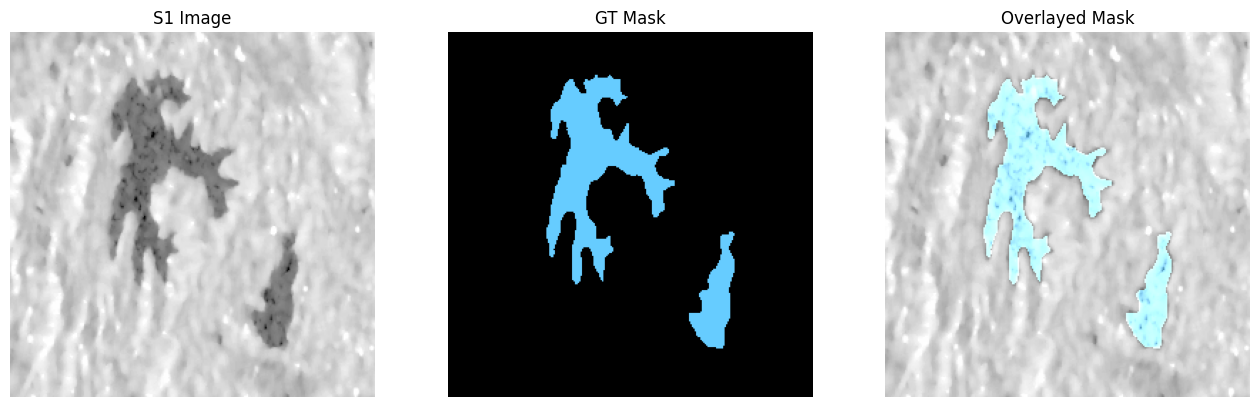

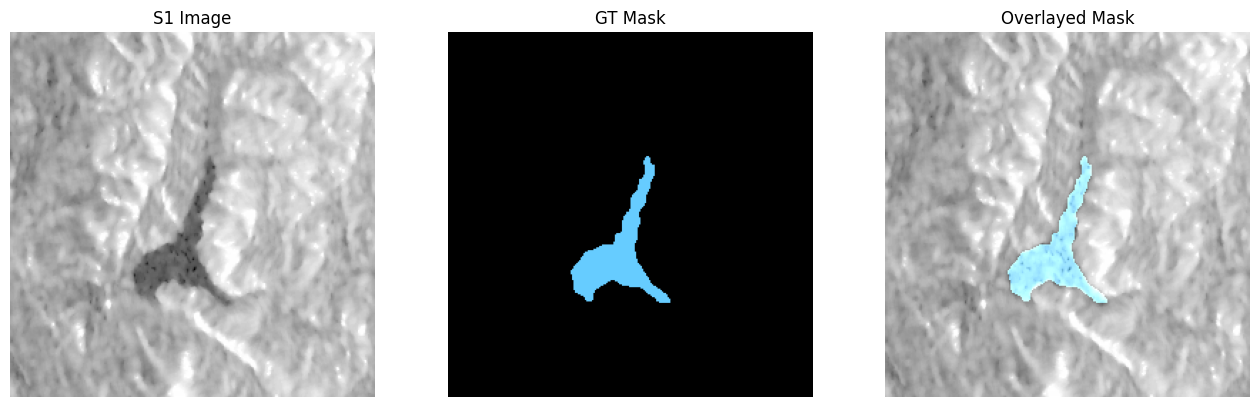

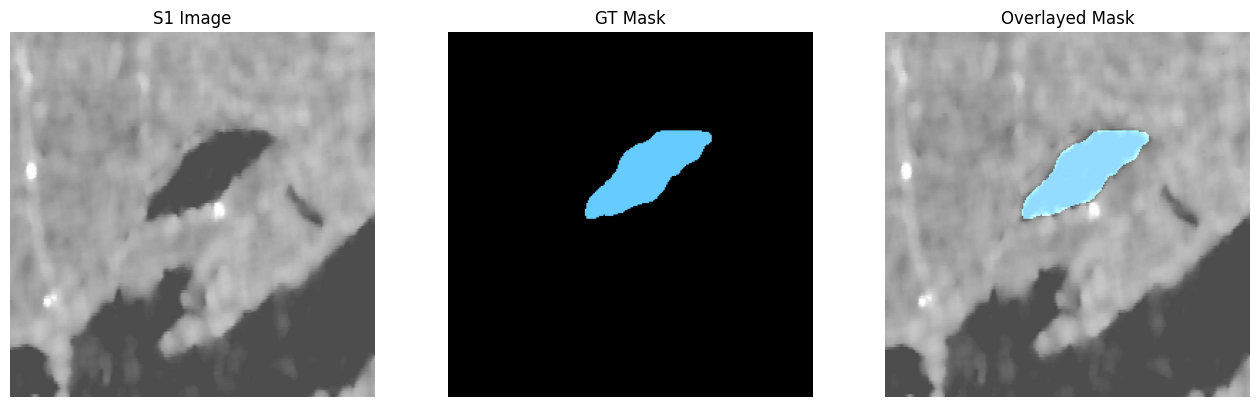

In [21]:
plot_train_ds = train_ds.map(unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["S1 Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):

    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=True)

## 데이터 증강


In [22]:
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=data_config.BRIGHTNESS_FACTOR,
                                         value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=data_config.CONTRAST_FACTOR,
                                       value_range=(0, 255)),
    ]
)

In [23]:
train_dataset = (
                train_ds.shuffle(data_config.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
                valid_ds.batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

`keras_cv.visualization.plot_segmentation_mask_gallery` API를 사용하여 훈련 데이터에서 몇 가지 이미지와 해당 분할 마스크를 시각화해 보겠습니다.

### 증강 데이터 시각화


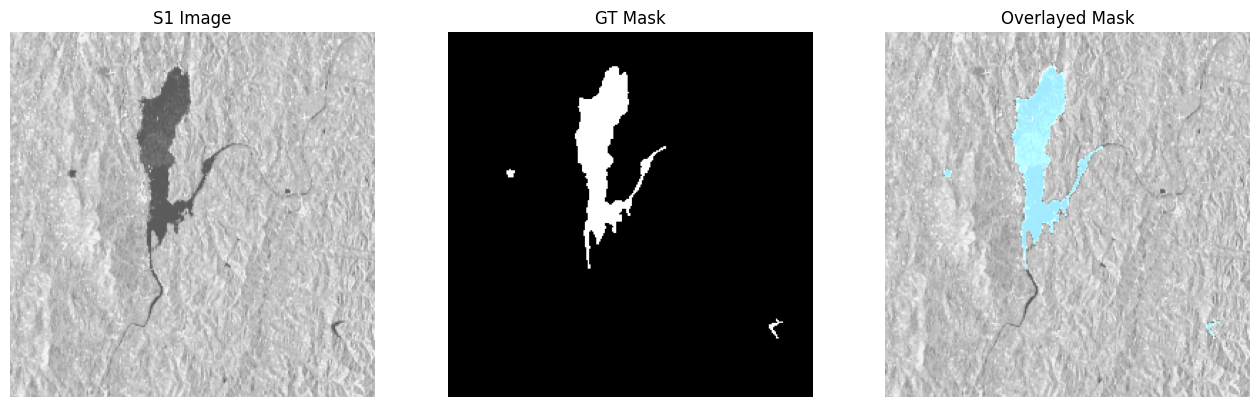

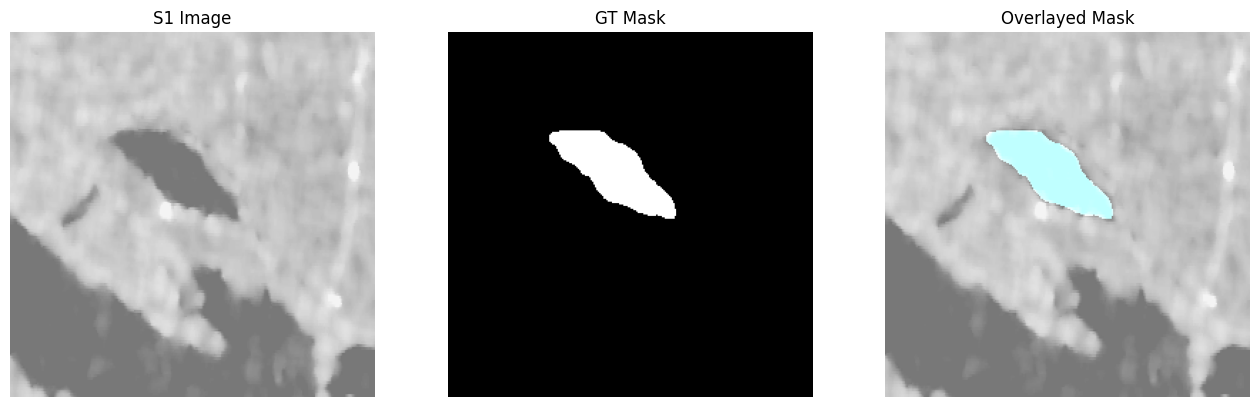

In [24]:
image_batch, aug_mask_batch = next(iter(train_dataset.take(1)))

titles = ["S1 Image", "GT Mask", "Overlayed Mask"]

for idx, (image, gt_mask) in enumerate(zip(image_batch, aug_mask_batch)):
    if idx > 1:
        break
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=False)

## 모델 아키텍처

우리는 DeepLabv3 Head 위에 `resnet50_v2_imagenet` 기능 추출기를 사용할 것입니다.

In [25]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = train_config.MODEL,
                                                          input_shape=data_config.IMAGE_SIZE+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=data_config.NUM_CLASSES, backbone=backbone,
    )
print(model.summary())

100%|██████████| 886/886 [00:00<00:00, 861kB/s]


100%|██████████| 90.3M/90.3M [00:02<00:00, 43.1MB/s]


Model: "deep_lab_v3_plus"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 64, 64, 256),  │     23,556,608 │ input_layer[0][0]      │
│                           │ (None, 8, 8, 2048)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_pyramid_pooling   │ (None, 8, 8, 256)      │     15,538,176 │ functional[0][1]       │
│ (SpatialPyramidPooling)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_output_upsampling │ (None, 64, 64, 256)    │              0 │ spatial_pyramid_pooli… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 64, 64, 48)     │         12,480 │ functional[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 304)    │              0 │ encoder_output_upsamp… │
│                           │                        │                │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 256, 256, 2)    │         79,360 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,186,624 (149.49 MB)

 Trainable params: 39,141,600 (149.31 MB)

 Non-trainable params: 45,024 (175.88 KB)

None


## 평가 지표

IoU(Intersection over Union)는 모델의 정확도를 평가하기 위해 분할 문제에서 자주 사용되는 메트릭입니다. 특정 클래스의 픽셀의 (불균형한) 백분율에 의해 편향되지 않는 정확도에 대한 보다 직관적인 기준을 제공합니다.

In [26]:
def mean_iou(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    union = total - intersection

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

### Tensorboard 및 ModelCheckpoint 콜백

In [27]:
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):

    # 로깅을 위해 텐서보드 콜백을 초기화합니다.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )


    # 최상의 모델 가중치를 저장하는 경우 파일 경로를 업데이트합니다.
    if save_weights_only:
        checkpoint_filepath = train_config.CKPT_DIR

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [tensorboard_callback, model_checkpoint_callback]

## 모델 학습

이제 `Trainingconfig` 클래스에 정의된 구성을 사용하여 `model.fit()`를 호출하여 모델을 생성하고 컴파일하고 학습해 보겠습니다.

In [28]:
# 모델을 구축합니다.

# 콜백을 받으세요.
callbacks = get_callbacks(train_config)
# 손실을 정의하세요.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# 컴파일 모델.
model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou],
)

In [29]:
# 각 에포크가 끝날 때마다 검증을 수행하여 모델을 훈련합니다.
history = model.fit(
    train_dataset,
    epochs=train_config.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3801 - loss: 1.0343 - mean_iou: 0.2116
Epoch 1: val_mean_iou improved from -inf to 0.11188, saving model to checkpoints/deeplabv3_plus_resnet50_v2.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.3875 - loss: 1.0250 - mean_iou: 0.2165 - val_accuracy: 0.2103 - val_loss: 1.6795 - val_mean_iou: 0.1119
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9659 - loss: 0.2769 - mean_iou: 0.6856
Epoch 2: val_mean_iou improved from 0.11188 to 0.50506, saving model to checkpoints/deeplabv3_plus_resnet50_v2.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9661 - loss: 0.2751 - mean_iou: 0.6860 - val_accuracy: 0.9688 - val_loss: 0.1711 - val_mean_iou: 0.5051
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9782 - loss: 0.1281 - mean_iou: 0.7116
Epoch 3: val_mean_iou improved from 0.50506 to 0.51915, saving model to checkpoints/deeplabv3_plus_resnet50_v2.weights.h5
26/26 ━━━━━━━━━━━

#### 미세 조정된 모델 가중치 로드

In [30]:
model.load_weights(train_config.CKPT_DIR)

#### 평가 수행

In [31]:
evaluate = model.evaluate(valid_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.9935 - loss: 0.0194 - mean_iou: 0.8839


#테스트 데이터로 세그먼트 실행

In [32]:
# 데이터 세트를 다운로드하세요.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # tar파일을 추출합니다.
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

In [33]:
DATASET_URL = r"https://www.dropbox.com/scl/fi/sav71j511j4edswjxywt3/Test12imagesS1.zip?rlkey=519a3ac7zpw3b7ft70uo65av1&st=b0l26j11&dl=1"
DATASET_DIR = "Test12imagesS1"
DATASET_ZIP_PATH = os.path.join(os.getcwd(), f"{DATASET_DIR}.zip")

# 데이터 세트가 존재하지 않으면 다운로드합니다.
if not os.path.exists(DATASET_DIR):
    download_and_unzip(DATASET_URL, DATASET_ZIP_PATH)
    os.remove(DATASET_ZIP_PATH)

In [34]:
DATASET_DIR = "Test12imagesS1"
data_images = glob.glob(os.path.join(DATASET_DIR, "Images", "*.png"))
data_masks = glob.glob(os.path.join(DATASET_DIR, "Masks", "*.png"))

# 데이터를 준비하기 전에 데이터 경로를 섞습니다.
zipped_data = list(zip(data_images, data_masks))
random.shuffle(zipped_data)
data_images, data_masks = zip(*zipped_data)
data_images = list(data_images)
data_masks = list(data_masks)

In [35]:
org_data = tf.data.Dataset.from_tensor_slices((data_images, data_masks))

훈련-검증 분할

In [36]:
SPLIT_RATIO = 1
# 검증 샘플 수를 결정하세요
NUM_VAL = int(len(data_images) * SPLIT_RATIO)

# 데이터 세트를 학습 세트와 검증 세트로 분할
train_data = org_data.take(NUM_VAL)
valid_data = org_data.take(NUM_VAL)

In [37]:
print(f"Train samples: {train_data.cardinality().numpy()}")
print(f"Validation samples: {valid_data.cardinality().numpy()}")

Train samples: 12
Validation samples: 12


데이터 및 임계값 마스크 로드

In [38]:
def read_image_mask(image_path, mask=False, size = data_config.IMAGE_SIZE):
    image = tf.io.read_file(image_path)

    if mask:
        image = tf.image.decode_jpeg(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=size, method = "bicubic")

        image_mask = tf.zeros_like(image)
        cond = image >=1
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)

    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=size, method = "bicubic")
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)

    return image

In [39]:
def load_data(image_list, mask_list):
    image = read_image_mask(image_list)
    mask  = read_image_mask(mask_list, mask=True)
    return {"images":image, "segmentation_masks":mask}

In [40]:
train_ds = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

이미지 및 세그먼테이션 마스크 압축 해제

In [41]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

실제 사실 시각화

In [42]:
# Dictionary mapping class IDs to colors.
id2color = {
    0: (0,  0,    0),    # Background
    1: (102, 204, 255),  # Waterbody
 }

In [43]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):

    # single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[num_arr==k] = color_map[k]

    return output.astype(np.uint8)

In [44]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

몇 개의 기준 진실 이미지를 해당 기준 진실 마스크와 함께 표시해 보겠습니다. 그리고 그것을 이미지 입력에 오버레이해 보겠습니다.

In [45]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):

    # 회색조 분할 맵에서 RGB 분할 맵을 만듭니다.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list)==3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask

    # 오버레이된 이미지를 만듭니다.
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)

    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)

    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")

        else:
            axis.imshow(data_list[idx])

        axis.axis('off')

    plt.show()

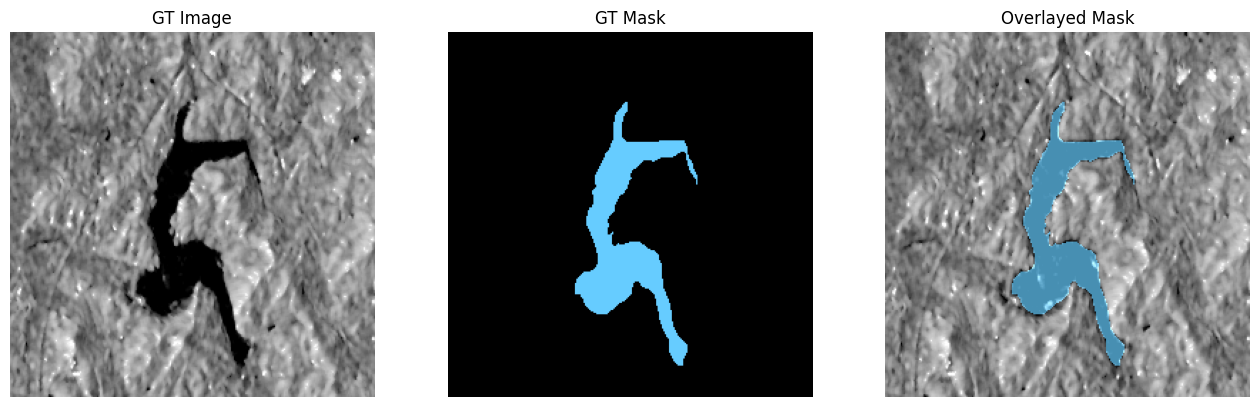

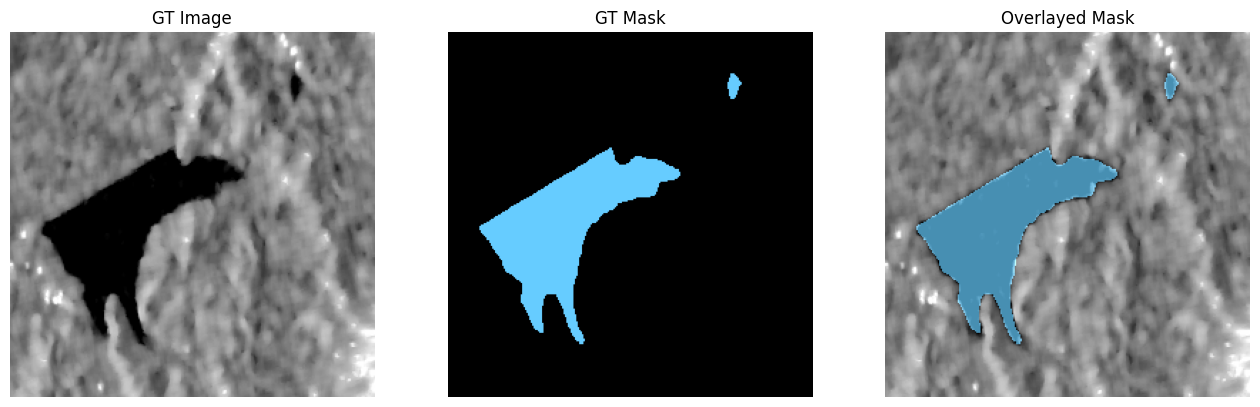

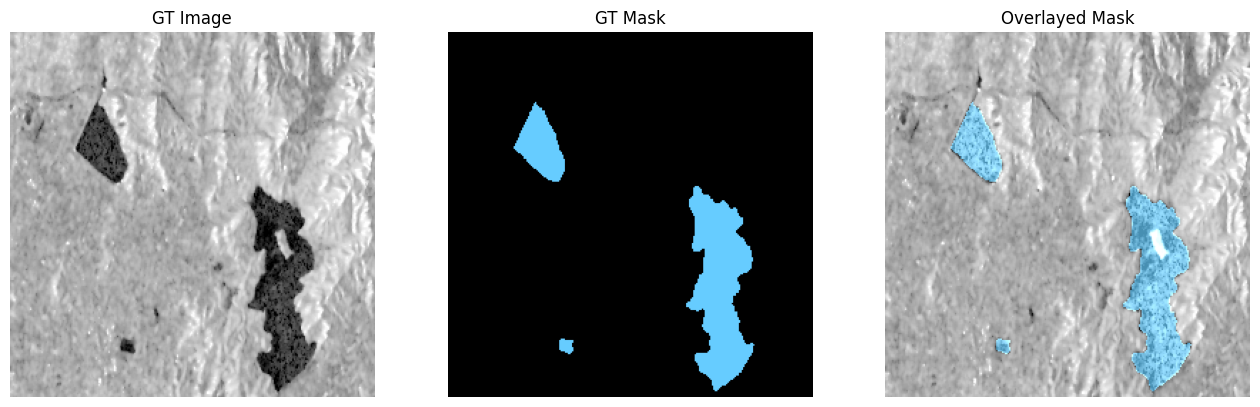

In [46]:
plot_train_ds = train_ds.map(unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):

    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=True)

In [47]:
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=data_config.BRIGHTNESS_FACTOR,
                                         value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=data_config.CONTRAST_FACTOR,
                                       value_range=(0, 255)),
    ]
)

In [48]:
train_dataset = (
                train_ds.shuffle(data_config.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
                valid_ds.batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

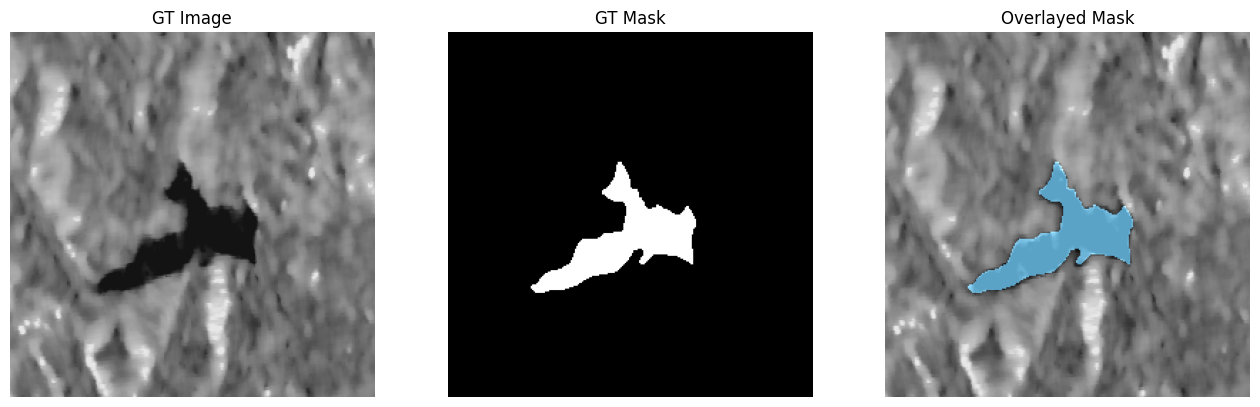

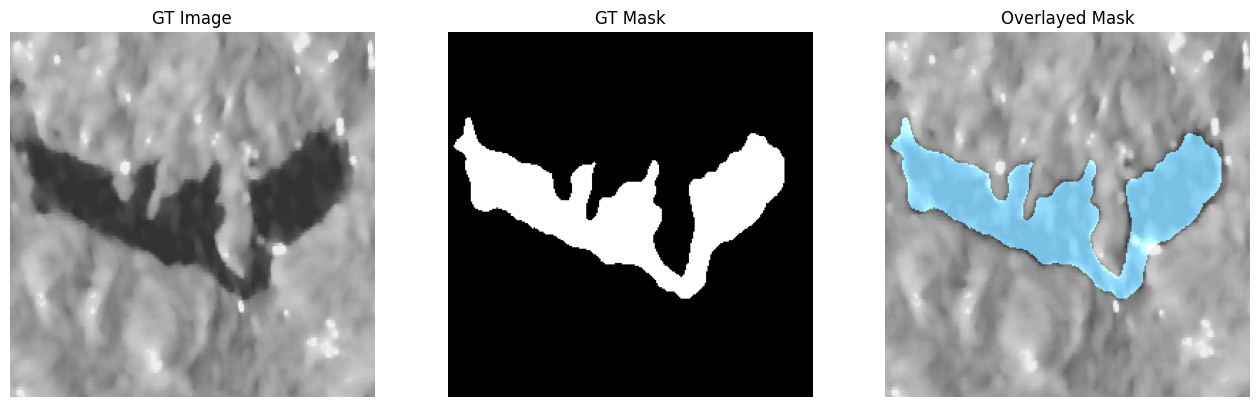

In [49]:
image_batch, aug_mask_batch = next(iter(train_dataset.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for idx, (image, gt_mask) in enumerate(zip(image_batch, aug_mask_batch)):
    if idx > 1:
        break
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=False)

미세 조정된 모델 가중치 로드

In [50]:
model.load_weights(train_config.CKPT_DIR)

# 미세 조정 모델을 사용한 예측

In [51]:
def inference(model, dataset, samples_to_plot):

    num_batches_to_process = 1
    count = 0
    stop_plot = False

    titles = ["S1 Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):

        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype('float32')
        batch_pred = batch_pred.argmax(axis=-1)

        batch_img  = batch_img.numpy().astype('uint8')
        batch_mask = batch_mask.numpy().squeeze(axis=-1)

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count+=1
            display_image_and_mask([image, mask, pred],
                                  title_list=titles,
                                   figsize=(20,8),
                                   color_mask=True)
            if count >= samples_to_plot:
                stop_plot=True
                break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


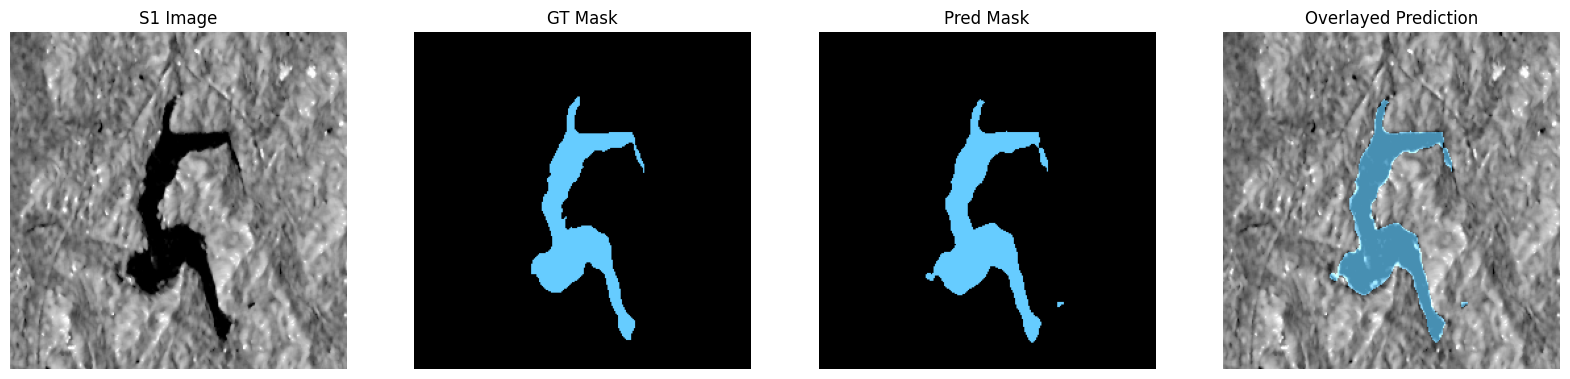

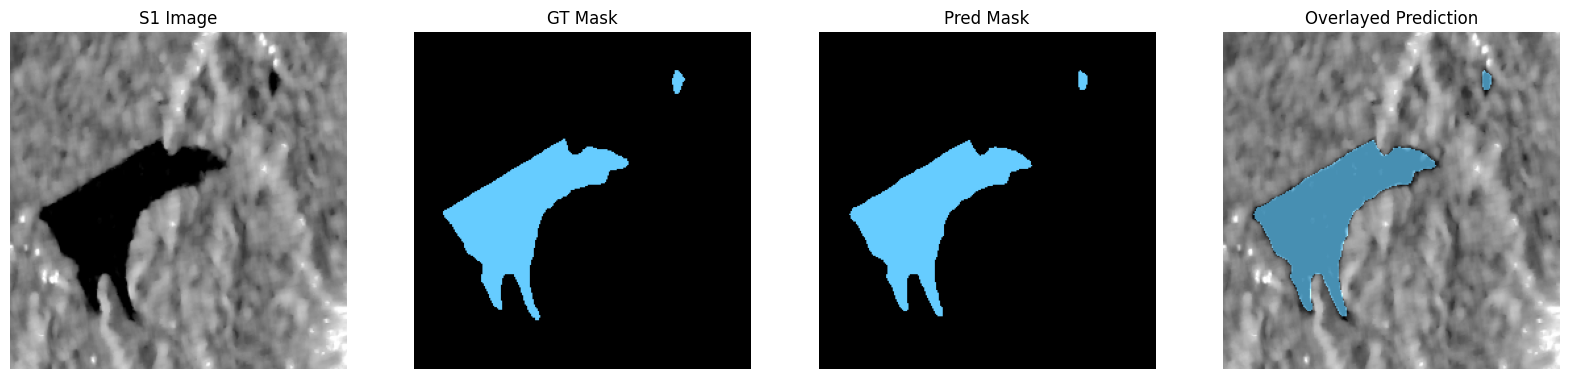

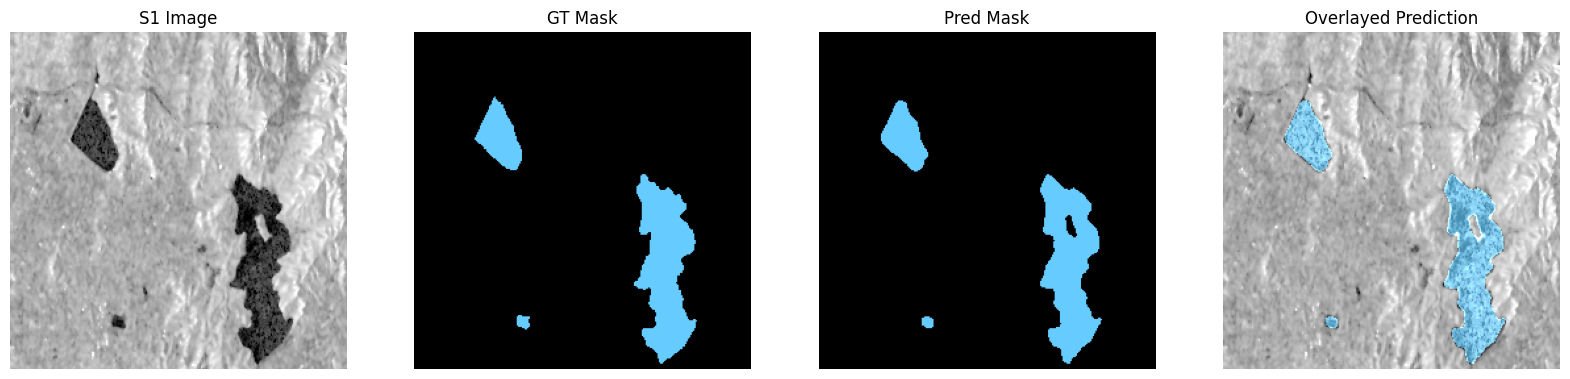

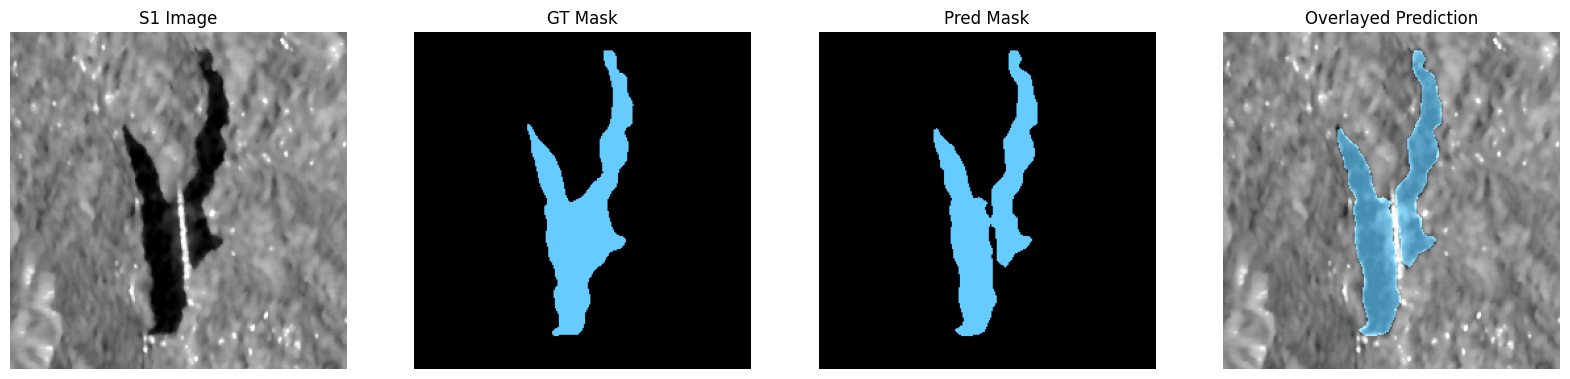

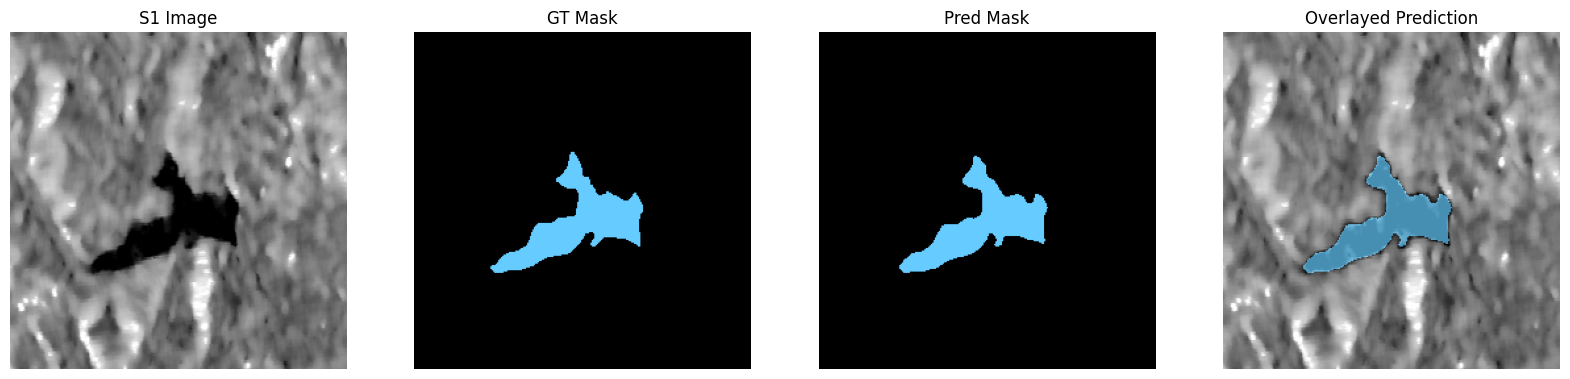

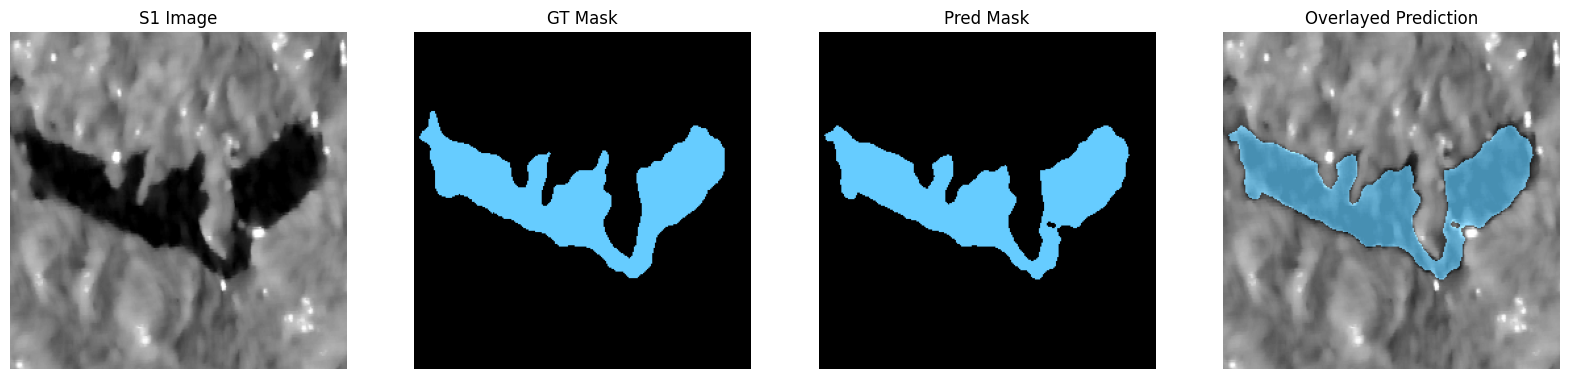

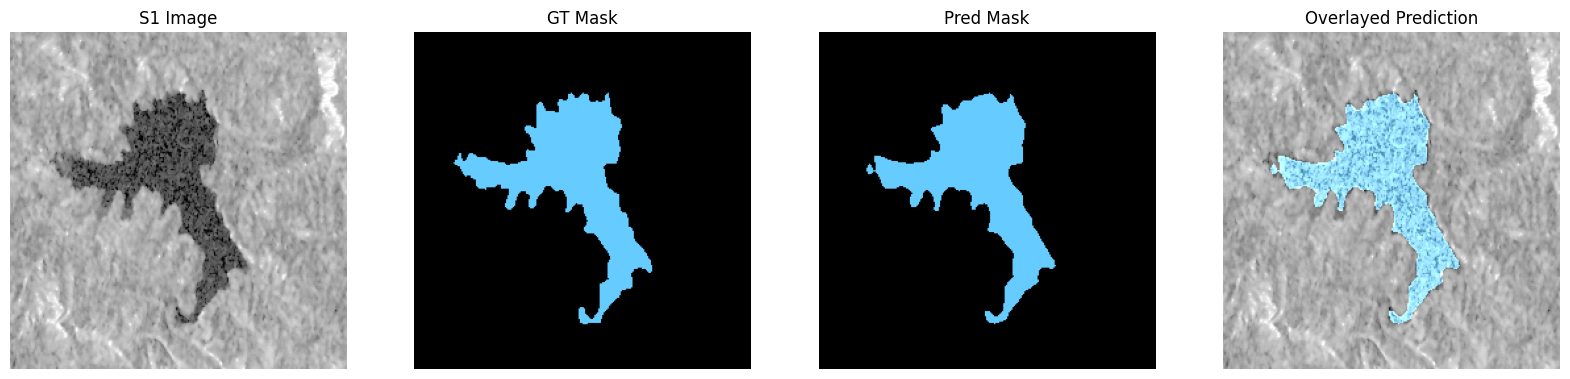

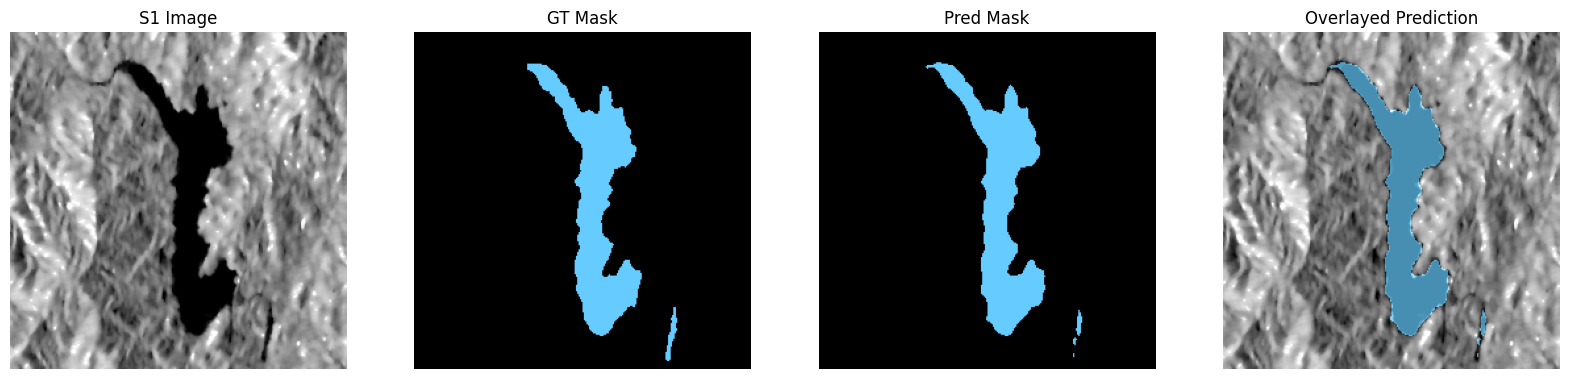

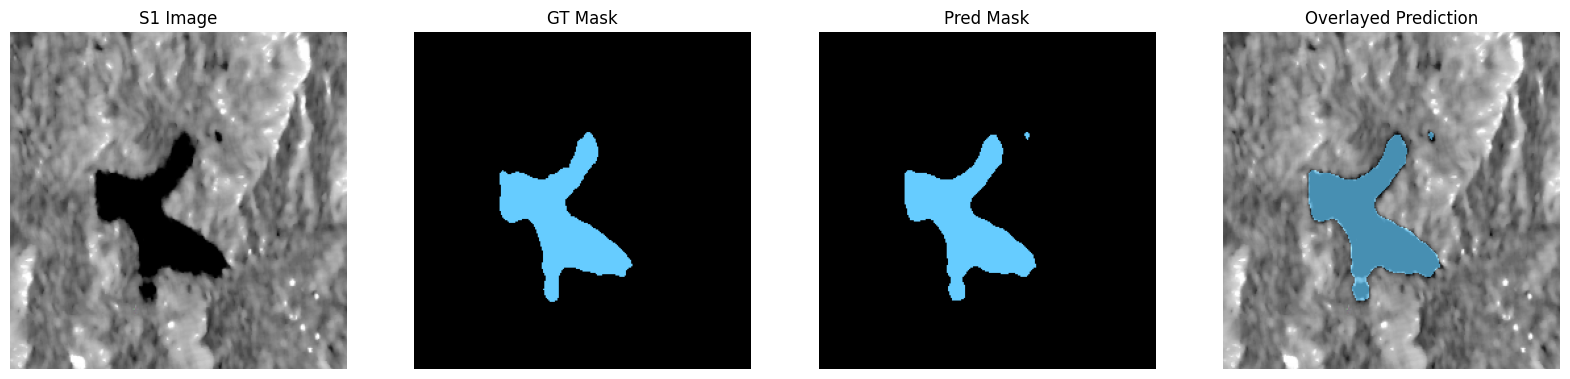

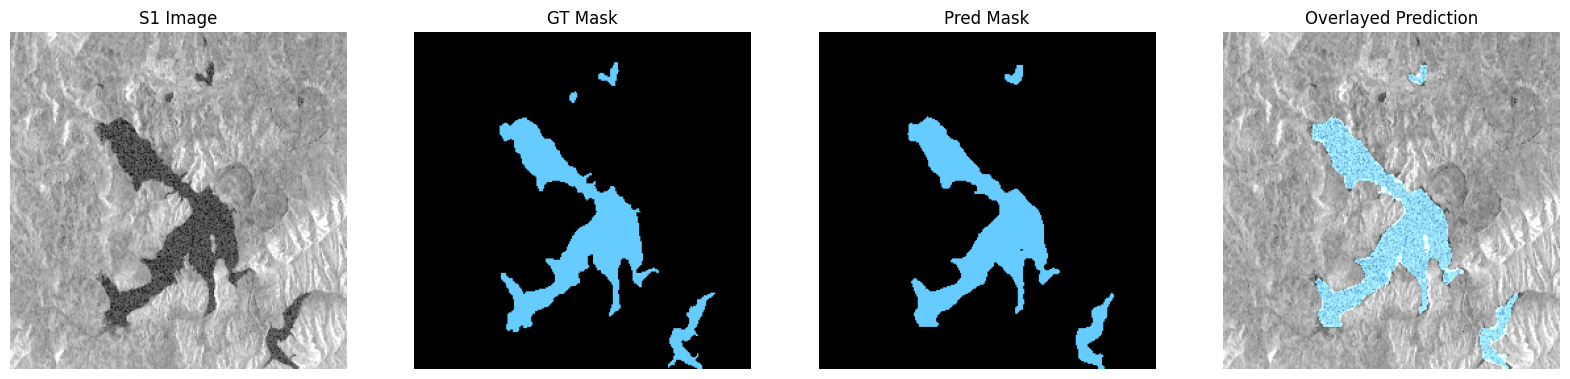

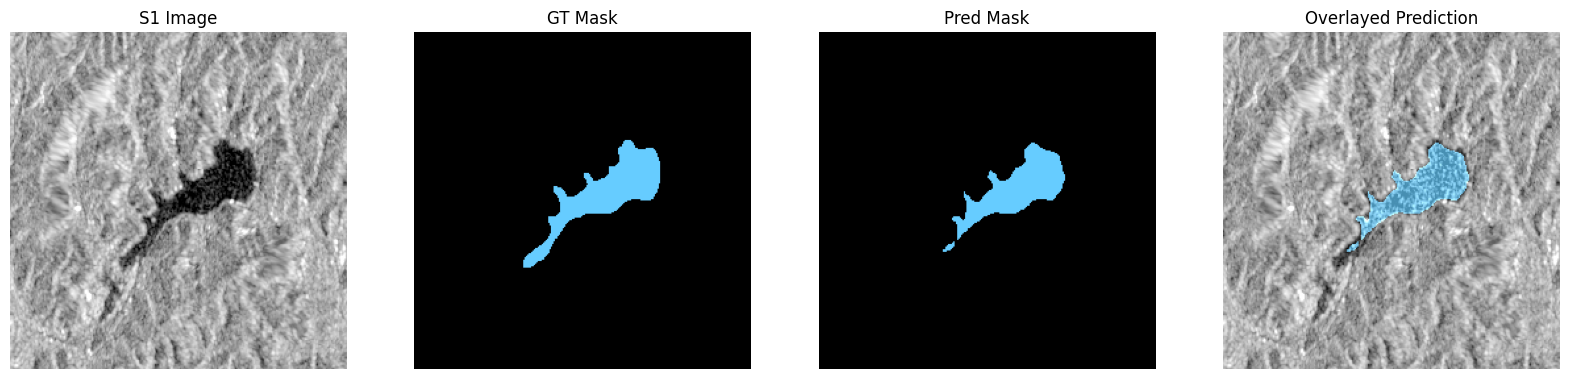

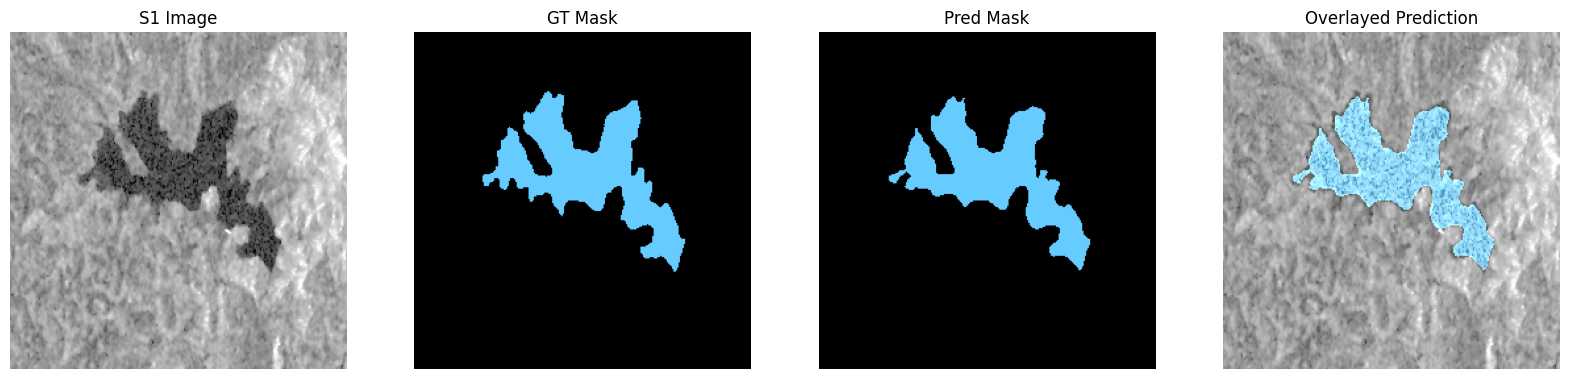

In [52]:
inference(model, valid_dataset, samples_to_plot=12)